In [2]:
import pandas as pd # used to load individual files
import numpy as np # not currently used
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
import peartree as pt # used to construct network
import matplotlib.pyplot as plt
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import networkx as nx
import geopandas as gp
from collections import defaultdict
from geopy.distance import geodesic


In [9]:
with open('rejsekort_graph_cleaned.gpickle', 'rb') as f:
    G = pickle.load(f)

# Relabels nodes by removing WPDOS_ from each node
# relabel_dic = {node:node[6:] for node in G.nodes()}
# G = nx.relabel_nodes(G, relabel_dic, copy=False)



In [8]:
G["000461011300"]

AdjacencyView({'000461101800': {0: {'length': 60.0, 'mode': 'transit'}}})

c:\Users\johan\anaconda3\envs\gds_py\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\johan\anaconda3\envs\gds_py\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


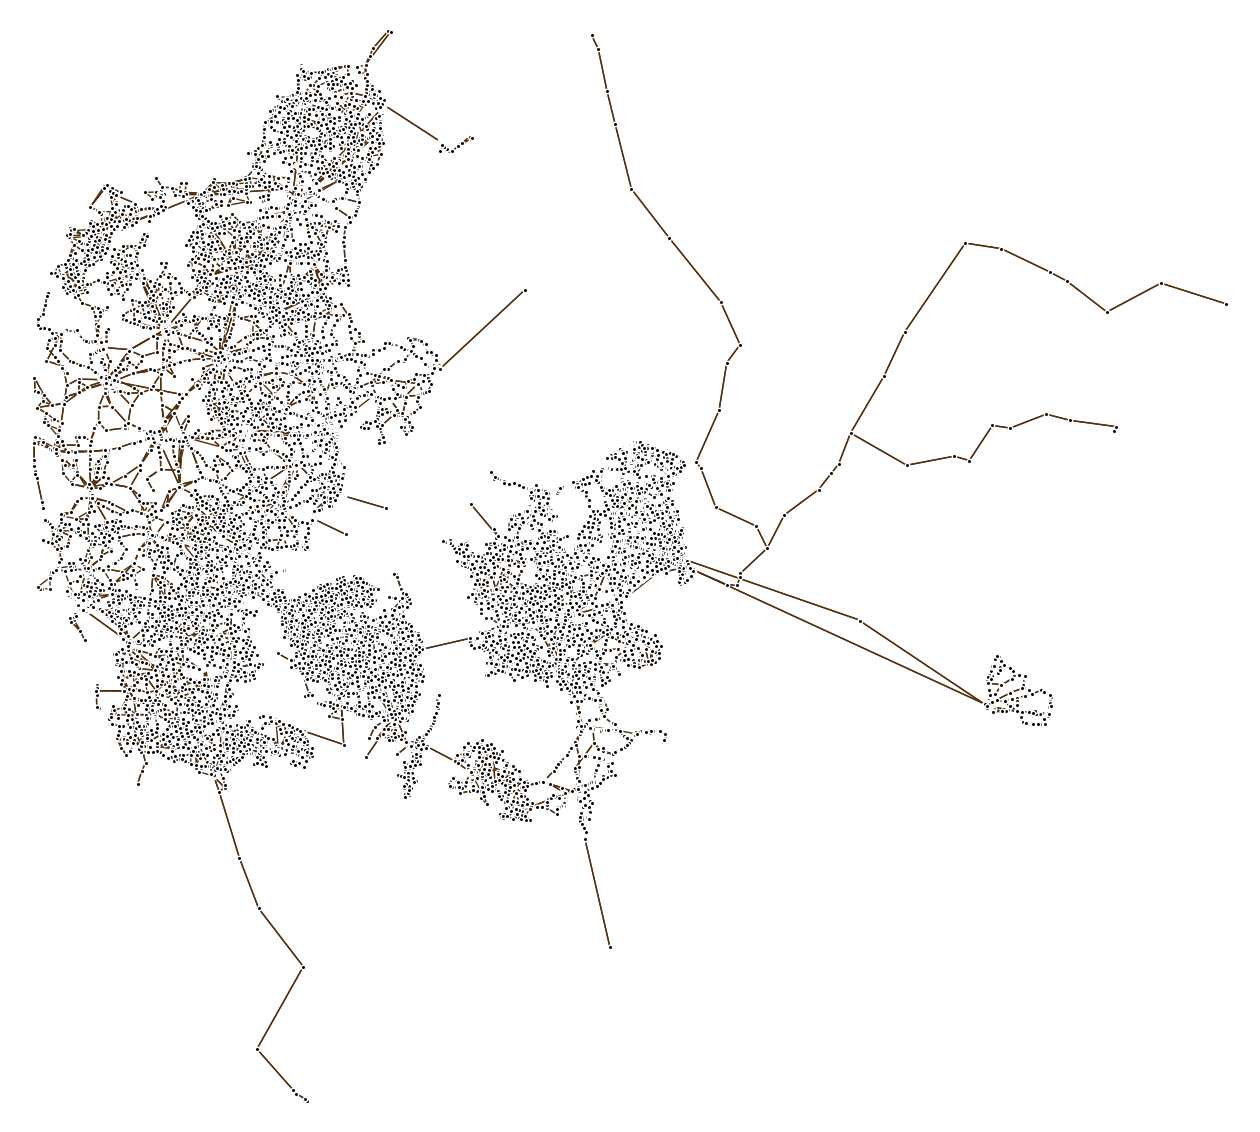

In [7]:
fig, ax = ox.plot_graph(G,
               figsize = (16,16),
                show=False,
                close=False,
                node_color='black',
                node_edgecolor="white",
                node_size=10,
                node_zorder=10,
                edge_color='#522F0D',
                edge_alpha=1,
                edge_linewidth = 1,
                bgcolor='None',
                #bbox= bbox_,
               #bgcolor='black'
              
             );

Modes of transport from GTFS reference
109 s-tog
700 bus
715 demand and response bus service
0 letbanen lightrail
1 is metro
2 train/intercity
3 localtog and bus?
4 ferry maybe other too?

Types of busses
S bus is fast and direct bus routes
e bus are express buslines during rush hour
p bus are local buses
n bus are night buses
havn bus




In [16]:
modes= [G.nodes[node]["modes"] for node in G.nodes()]
uniqmodes = set()
for mode in modes:
    uniqmodes = uniqmodes.union(set(mode))
uniqmodes

{'0', '1', '109', '2', '3', '4', '700', '715'}

In [20]:
edges = G.edges()

In [31]:
G.nodes()['O4LSS_000000000002']

{'boarding_cost': 1135.7628596338277,
 'modes': ['3'],
 'y': 55.767248497366,
 'x': 12.498017540594}

In [32]:
G['O4LSS_000000000002']

AdjacencyView({'O4LSS_000000000003': {0: {'length': 60.0, 'mode': 'transit'}}})

In [40]:
mode_counts=defaultdict(int)
for edge in G.edges():
    edge = G.get_edge_data(*edge)
    mode_counts[edge[0]['mode']] += 1
print(mode_counts)

defaultdict(<class 'int'>, {'transit': 52031})


In [39]:
def tacicab_sphere(latlong1,latlong2):
    '''
    Returns the taxicab distance between two points on a sphere (given lat-long pairs).
    Formula: http://cs.ucmo.edu/~mjms/2005.1/bayar.pdf
    '''
    x1,y1 = latlong1
    x2,y2 = latlong2
    return min(
        geodesic((x1,y1),(x2,y1)).meters + geodesic((x2,y1),(x2,y2)).meters,
        geodesic((x1,y1),(x1,y2)).meters + geodesic((x1,y2),(x2,y2)).meters
    )

def m2s(m):
    return m/1.25 #Walking speed used by Google Maps

0

In [ ]:
def add_walk_edges(G):
    G = G.copy()
    for node1 in tqdm(G.nodes()):
        for node2 in G.nodes():
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G

In [5]:
G["O4LSS_000461011300"]

AdjacencyView({'O4LSS_000461101800': {0: {'length': 60.0, 'mode': 'transit'}}})